Variational Monte Carlo is a method to evaluate the integral $$\frac{ \int |\Psi(R)|^2 O(R) dR}{\int |\Psi(R)|^2} dR. $$

The integral calculates the expectation value of the operator $O(R)$.

To evaluate it we use the Markov Chain Monte Carlo.

* ` Step-1`: Choose a new trail location for the particles.
* `Step-2`: Evaluate the ratio squared of the wavefunctions for the new and old trail wavefunctions.
* `Step-3`: If the ratio squared is greater than some random number, we keep the new trail location, otherwise keep the old trail location.


Hydrogen molecule has only two electrons (one spin up and one spin down), we need not be concerned with computing determinants. We will be optimizing two very simple trial wave functions $\Psi_1$ and $\Psi_2$. 

Let our molecule be centered at the origin with protons at $\pm L/2 \hat{x}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stats

## Building the Wavefunction

The first trial function is a simple bond-centered Gaussian with width controlled by the parameter $\alpha$, $\Psi(r_1,r_2;\alpha)=\exp[-\alpha(|r_1|^2+|r_2|^2)]$ where $\alpha$ is to be optimized variationally.

where $r_1$ and $r_2$ denotes position of electron 1 and 2 respectively.

In [2]:
def psi(coords,ions,alpha=0.5): 
    '''
    coord : Numpy 2D array denoting position of electrons
    ions : Numpy 2D array denoting position of proton/nucleus
    alpha : Variational parameter that is arbitrarly set to 0.5
    '''

    r1 = np.linalg.norm(coords[0])**2
    r2 = np.linalg.norm(coords[1])**2

    wavefn = np.exp(-1*alpha*(r1+r2))

    return wavefn
    


In [3]:
## Testing Trail wavefunction

def WaveFunction1_test1(wavefunction):
   coords=np.array([[1.0,0.5,0.3],[-0.2,0.1,-0.1]])
   ions=np.array([[0.7,0.0,0.0],[-0.7,0.0,0.0]])
   if np.abs(wavefunction(coords,ions)-0.496585)<1e-5:
      return True
   else:
      return False

if WaveFunction1_test1(psi):
   print("Wavefunction Test passed")
else:
   print("Wavefunction Test Failed")

Wavefunction Test passed


In [4]:
coords=np.array([[1.0,0.5,0.3],[-0.2,0.1,-0.1]])
ions=np.array([[0.7,0.0,0.0],[-0.7,0.0,0.0]])

In [5]:
psi(coords,ions)

0.4965853037914094

## Building a Monte Carlo Code

The next step in producing Monte Carlo code is finding a way to move particles. One approach which is may not be efficient is to move particles in small box around their current position.

In [6]:
def VMC(WF,ions, numSteps:int=1000,box_length:float=1.5):
    coords = np.zeros((2,3),float) # initializing the position of electrons
    movesAttempted = 0.0
    movesAccepted = 0.0
    # electrons are moved in a space defined box defined by the box_length

    for steps in range(numSteps):
        for ptcl in range(len(coords)):
            movesAttempted+=1
            shift = np.random.uniform(-box_length/2,box_length/2,3)
            new_coords = coords+shift
            WF_new = WF(new_coords,ions)
            WF_old = WF(coords,ions)
            r = (WF_new/WF_old)**2
            

            if r>np.random.rand():
                movesAccepted+=1
                coords = new_coords
            else:
                pass
    # Compute and print the acceptance ratio
    acceptance_ratio = movesAccepted / movesAttempted
    print("Acceptance ratio: ", acceptance_ratio)
    return acceptance_ratio

In [7]:
## Testing
coords=np.array([[1.0,0.5,0.3],[-0.2,0.1,-0.1]])
ions=np.array([[-0.7,0.0,0.0],[0.7,0.0,0.0]])

r = VMC(psi,ions)

Acceptance ratio:  0.4815


## Computing the Local Energy

The average energy of the system is defined as:

$$\langle H\Psi / \Psi \rangle \equiv \langle E_L \rangle$$

where $E_L$ is called the Local Energy and $$\frac{H\Psi}{\Psi} = \frac{(-\nabla^2/2 + V)\Psi}{\Psi}$$.

The term $(V\Psi)/\Psi$ reduces to $$V(r)=-\sum_{Ie} \frac{1}{r_{Ie}} + \sum_{ee} \frac{1}{r_{ee}}+\sum_{II}\frac{1}{r_{II}}$$ for system of electrons and ions. In real code, we would want to have analytic derivatives for the $\nabla^2 \Psi / \Psi$ term, we compute it with finite differences in this tutorial.

Remember that $$\frac{\partial^2 F}{\partial x^2} \approx \frac{F(x+\delta)+F(x-\delta)-2F(x)}{\delta^2}$$. Further, the Hamiltonian is represented in natural units.

In [8]:
def LaplacianPsiOverPsi(wavefunction,coords,ions):
    delta = 0.001

    delta_xyz = delta * np.eye(3)
    del2xyz = np.zeros(3,float)
    # finding the laplacian
    for i in range(3):
        cp = coords+delta_xyz[i]
        cm = coords-delta_xyz[i]
        del2xyz[i] = (wavefunction(cp,ions) + wavefunction(cm,ions) - 2*wavefunction(coords,ions))/delta**2
    
    return(-0.5*sum(del2xyz))

def LocalEnergy(wavefunction,coords,ions):
    # calculating rie
    diff_coords = coords[:,np.newaxis,:] - ions[np.newaxis,:,:]
    distance_matrix = np.linalg.norm(diff_coords, axis=-1)
    rie = distance_matrix.reshape(1,distance_matrix.size)[0]

    
    # calculating ree
    diff_coords = coords[:,np.newaxis,:] - coords[np.newaxis,:,:]
    distance_matrix = np.linalg.norm(diff_coords, axis=-1)
    # Extract the upper triangular elements, excluding the diagonal
    upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
    ree = distance_matrix[upper_tri_indices]

    # calculating rii
    diff_ions = ions[:,np.newaxis,:] - ions[np.newaxis,:,:]
    distance_matrix = np.linalg.norm(diff_ions, axis=-1)
    # Extract the upper triangular elements, excluding the diagonal
    upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
    rii = distance_matrix[upper_tri_indices]

    v = -1*sum(1/rie)+sum(1/ree)+sum(1/rii)
    #print('potential_enegy =',v)
    del2 = LaplacianPsiOverPsi(wavefunction,coords,ions)
    #print('kinetic_energy =',del2)

    El = (del2/wavefunction(coords,ions))+v
    return v,El

In [9]:
ions=np.array([[0.7,0.0,0.0],[-0.7,0.0,0.0]])

R=np.zeros((2,3),float)
R[0]=[1.0,0.3,0.2]
R[1]=[2.0,-0.2,0.1]

LocalEnergy(psi,R,ions)

(-2.229490759385763, -3.7794910847005374)

In [10]:
def VMC(WF,ions,initial_coords,numSteps:int=10000,box_length:float=1.5):

    coords = initial_coords

    movesAttempted = 0.0
    movesAccepted = 0.0
    # electrons are moved in a space defined box defined by the box_length
    local_energy = np.array([])

    for steps in range(numSteps):
        for ptcl in range(len(coords)):
            movesAttempted+=1
            shift = np.random.uniform(-box_length/2,box_length/2,3)
            new_coords = coords+shift
            WF_new = WF(new_coords,ions)
            WF_old = WF(coords,ions)
            r = (WF_new/WF_old)**2
            

            if r>np.random.rand():
                movesAccepted+=1
                coords = new_coords
                local_energy = np.append(local_energy,LocalEnergy(WF,coords,ions))
            else:
                pass
            
    # Compute and print the acceptance ratio
    acceptance_ratio = movesAccepted / movesAttempted
    print("Acceptance ratio: ", acceptance_ratio)
    return acceptance_ratio, local_energy

In [11]:
ions=np.array([[0.7,0.0,0.0],[-0.7,0.0,0.0]])
R=np.zeros((2,3),float)
R[0]=[1.0,0.3,0.2]
R[1]=[2.0,-0.2,0.1]
r,e=VMC(psi,ions,initial_coords=R)
print(len(e))

Acceptance ratio:  0.4782
19128


Text(0, 0.5, 'Local Energy (Hartrees)')

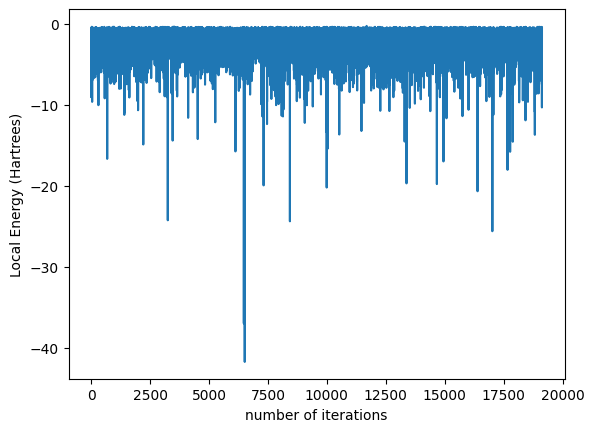

In [12]:
plt.plot(range(0,len(e)),e)
plt.xlabel('number of iterations')
plt.ylabel('Local Energy (Hartrees)')

In [13]:
stats.Stats(e)

(-2.181841575037282,
 2.904548616637003,
 0.016885614315971093,
 1.8776932438842964)

In [14]:
# VMC class

import numpy as np
import matplotlib.pyplot as plt
import stats

class WaveFunctionClass:

    def SetIons(self,ions):
        self.ions = ions
    
    def SetAlpha(self,alpha):
        self.alpha = alpha

    def wavefunction(self, coords,ions,alpha=0.5): 
        '''coords : Numpy 2D array denoting position of electrons
        ions : Numpy 2D array denoting position of proton/nucleus
        alpha : Variational parameter that is arbitrarly set to 0.5
        '''
        if ions.any() == None:
            ions = self.ions
        if not alpha:
            alpha = self.alpha

        r1 = np.linalg.norm(coords[0])**2
        r2 = np.linalg.norm(coords[1])**2

        wavefn = np.exp(-1*alpha*(r1+r2))

        return wavefn
    
    def LaplacianPsiOverPsi(self,coords):
        '''
        wavefunction : trail wavefunction
        coords : Numpy 2D array denoting position of electrons
        ions : Numpy 2D array denoting position of proton/nucleus
        '''
        delta = 0.001

        delta_xyz = delta * np.eye(3)
        del2xyz = np.zeros(3,float)
        # finding the laplacian
        for i in range(3):
            cp = coords+delta_xyz[i]
            cm = coords-delta_xyz[i]
            del2xyz[i] = (self.wavefunction(cp,ions) + self.wavefunction(cm,ions) - 2*self.wavefunction(coords,ions))/delta**2
        
        return(-0.5*sum(del2xyz))

    def LocalEnergy(self,coords):
        
        '''
        wavefunction : trail wavefunction
        coords : Numpy 2D array denoting position of electrons
        ions : Numpy 2D array denoting position of proton/nucleus
        '''
        # calculating rie
        diff_coords = coords[:,np.newaxis,:] - ions[np.newaxis,:,:]
        distance_matrix = np.linalg.norm(diff_coords, axis=-1)
        rie = distance_matrix.reshape(1,distance_matrix.size)[0]

        
        # calculating ree
        diff_coords = coords[:,np.newaxis,:] - coords[np.newaxis,:,:]
        distance_matrix = np.linalg.norm(diff_coords, axis=-1)
        # Extract the upper triangular elements, excluding the diagonal
        upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
        ree = distance_matrix[upper_tri_indices]

        # calculating rii
        diff_ions = ions[:,np.newaxis,:] - ions[np.newaxis,:,:]
        distance_matrix = np.linalg.norm(diff_ions, axis=-1)
        # Extract the upper triangular elements, excluding the diagonal
        upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
        rii = distance_matrix[upper_tri_indices]

        v = -1*sum(1/rie)+sum(1/ree)+sum(1/rii)
        del2 = self.LaplacianPsiOverPsi(coords)

        local_energy = (del2/self.wavefunction(coords,ions))+v
        return local_energy
    
    def VMC(self,coords,numSteps:int=10000,box_length:float=1.5):

        movesAttempted = 0.0
        movesAccepted = 0.0
        # electrons are moved in a space defined box defined by the box_length
        local_energy = np.array([])

        for steps in range(numSteps):
            for ptcl in range(len(coords)):
                movesAttempted+=1
                shift = np.random.uniform(-box_length/2,box_length/2,3)
                new_coords = coords+shift
                WF_new = self.wavefunction(new_coords,ions)
                WF_old = self.wavefunction(coords,ions)
                r = (WF_new/WF_old)**2
                

                if r>np.random.rand():
                    movesAccepted+=1
                    coords = new_coords
                    local_energy = np.append(local_energy,self.LocalEnergy(coords))
                else:
                    pass
                
        # Compute and print the acceptance ratio
        acceptance_ratio = movesAccepted / movesAttempted
        #print("Acceptance ratio: ", acceptance_ratio)
        return acceptance_ratio, local_energy, stats.Stats(local_energy)

    


In [15]:
psi = WaveFunctionClass()
psi.SetAlpha(0.5)
psi.SetIons(np.array([[0.7,0.0,0.0],[-0.7,0.0,0.0]])) 


In [16]:
acceptance_ratio, local_energy, stats = psi.VMC(R)

In [17]:
stats

(-1.464389864448418,
 1.6154462546864976,
 0.015760190471183357,
 1.4672878921956947)

Text(0, 0.5, 'Local Energy (Hartrees)')

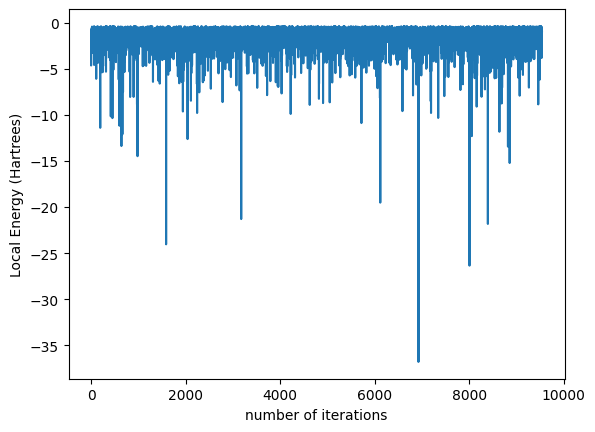

In [18]:
plt.plot(range(0,len(local_energy)),local_energy)
plt.xlabel('number of iterations')
plt.ylabel('Local Energy (Hartrees)')

In [19]:
psi.LocalEnergy(R)

-3.7794910847005374

## Reference 

- [VMC Tutorial by Bryan Clark](https://clark.physics.illinois.edu/Tutorials/VMCIntroTutorial/index.html)

#### Problems with the code
- the acceptance_ratio got is greater than the value given in the tutorial
- The local local_energy calculated is greater than the value given in the tutorial